# Import Libraries

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno

import datetime
from matplotlib.dates import DateFormatter

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fqdist
import re

from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import and Read Data

In [3]:
transactionData = pd.read_csv("C:/Users/DELL/Documents/Untitled Folder/QVI_transaction_data.csv")
purchaseData = pd.read_csv("C:/Users/DELL/Documents/Untitled Folder/QVI_purchase_behaviour.csv")

In [4]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
purchaseData.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [6]:
transactionData.shape

(264836, 8)

In [7]:
transactionData['TXN_ID'].nunique()

263127

##### Data have duplicate transaction id's.

In [8]:
transactionData[transactionData.duplicated(['TXN_ID'])].head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
42,43605,55,55073,48887,113,Twisties Chicken270g,1,4.6
377,43475,7,7364,7739,20,Doritos Cheese Supreme 330g,2,11.4
419,43391,12,12301,10982,93,Doritos Corn Chip Southern Chicken 150g,2,7.8
476,43351,16,16427,14546,81,Pringles Original Crisps 134g,1,3.7
511,43315,19,19272,16683,31,Infzns Crn Crnchers Tangy Gcamole 110g,2,7.6


In [9]:
transactionData[transactionData.duplicated(['TXN_ID'])].shape

(1709, 8)

In [10]:
# First duplicated transaction id

transactionData.loc[transactionData['TXN_ID'] == 48887, :]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
41,43605,55,55073,48887,4,Dorito Corn Chp Supreme 380g,1,3.25
42,43605,55,55073,48887,113,Twisties Chicken270g,1,4.60


In [11]:
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [12]:
transactionData.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

No null values are present. That's good!!

## Exploring both datasets


In [13]:
transactionData.columns

Index(['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES'],
      dtype='object')

In [14]:
transactionData['DATE'].head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

In [15]:
# Dates are not in right format, converting in yyyy-mm-dd format

def to_datetime(xl_date):
    start = datetime.datetime(1900,1,1)
    if(xl_date>60):
        delta = datetime.timedelta(days = xl_date-1)
    else:
        delta = datetime.timedelta(days = xl_date-2)
        
    conv_date = start+delta
    return conv_date




In [16]:
transactionData['DATE'] = transactionData['DATE'].apply(to_datetime)

In [17]:
transactionData['DATE'].head()

0   2018-10-18
1   2019-05-15
2   2019-05-21
3   2018-08-18
4   2018-08-19
Name: DATE, dtype: datetime64[ns]

In [18]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-18,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-15,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-21,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-18,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-19,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


#### Now Looking Good!!

In [19]:
transactionData['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

In [20]:
# Extracting Weights from Product names

transactionData['PROD_WT'] = transactionData['PROD_NAME'].str.extract("(\d+)")
transactionData['PROD_WT'] = pd.to_numeric(transactionData['PROD_WT'])
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT
0,2018-10-18,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-15,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-21,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-18,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-19,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


In [21]:
max(transactionData['PROD_WT'])

380

In [22]:
min(transactionData["PROD_WT"])

70

In [23]:
# Extracting Brand names from the "PROD_NAME" column
def Product_Company(grp):
    return grp["PROD_NAME"].split()[0]
transactionData['BRAND'] = transactionData.apply(Product_Company,axis=1)
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,BRAND
0,2018-10-18,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural
1,2019-05-15,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs
2,2019-05-21,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths
3,2018-08-18,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths
4,2018-08-19,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle


In [24]:
#Cleaning the text in PROD_NAME column

def clean_text(text):
    text = re.sub('[&/]',' ',text)
    text = re.sub('\d\w*',' ',text) 
    return text

transactionData['PROD_NAME']=transactionData['PROD_NAME'].apply(clean_text)

In [25]:
transactionData['PROD_NAME'].unique()[:10]

array(['Natural Chip        Compny SeaSalt ', 'CCs Nacho Cheese     ',
       'Smiths Crinkle Cut  Chips Chicken  ',
       'Smiths Chip Thinly  S Cream Onion  ',
       'Kettle Tortilla ChpsHny Jlpno Chili  ',
       'Old El Paso Salsa   Dip Tomato Mild  ',
       'Smiths Crinkle Chips Salt   Vinegar  ',
       'Grain Waves         Sweet Chilli  ',
       'Doritos Corn Chip Mexican Jalapeno  ',
       'Grain Waves Sour    Cream Chives  '], dtype=object)

In [26]:
# Removing salsa products 

transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(lambda x: x.lower())
transactionData = transactionData[~transactionData['PROD_NAME'].str.contains("salsa")]
transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(lambda x: x.title())

In [27]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,BRAND
0,2018-10-18,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural
1,2019-05-15,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCs
2,2019-05-21,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-18,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,Smiths
4,2018-08-19,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150,Kettle


In [28]:
transactionData['PROD_QTY'].value_counts()

2      220070
1       25476
5         415
3         408
4         371
200         2
Name: PROD_QTY, dtype: int64

Two occurences for 200 in dataset. Let's explore..

In [29]:
transactionData.loc[transactionData['PROD_QTY']==200,:]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,BRAND
69762,2018-08-20,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380,Dorito
69763,2019-05-21,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380,Dorito


Checking the total number of transactions made by the customer LYLTY_CARD_NBR

In [30]:
transactionData.loc[transactionData['LYLTY_CARD_NBR']==226000,:]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,BRAND
69762,2018-08-20,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380,Dorito
69763,2019-05-21,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380,Dorito


Only made two transactions over the entire year. So we can drop this customer (outliers) for better analysis

In [31]:
transactionData.drop(transactionData.index[transactionData['LYLTY_CARD_NBR'] == 226000], inplace = True)
purchaseData.drop(purchaseData.index[purchaseData['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [32]:
transactionData.loc[transactionData['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,BRAND


It is dropped successfully

In [33]:
# Now let's examine the transactions over time to check missing dates (if any)

transactionData['DATE'].nunique()

364

In [34]:
date_sales = pd.DataFrame(transactionData.groupby("DATE").agg({'TOT_SALES':'sum'}))

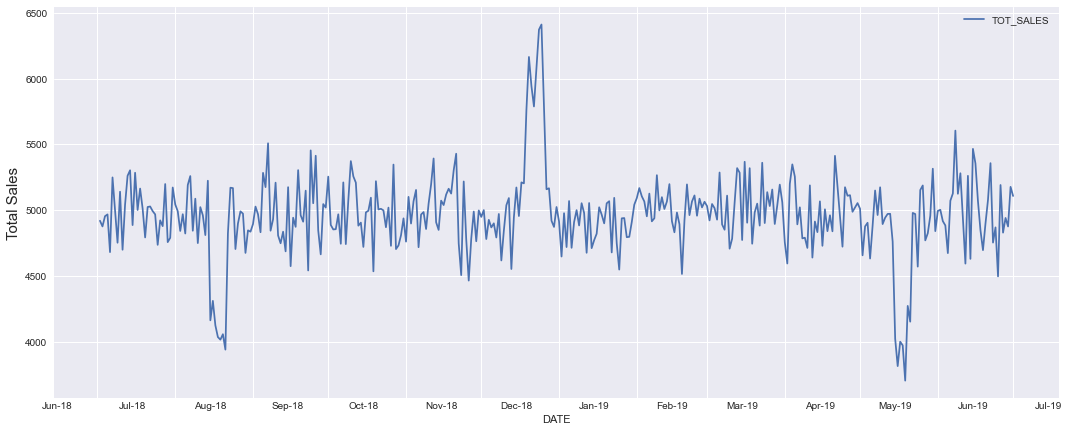

In [35]:
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.style.use('seaborn')
fig = date_sales.plot(figsize=(18,8))
plt.ylabel("Total Sales",{'fontsize':15})
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

In december there is high sales and there is a drop in middle. 

In [36]:
# Now examining december month

december = pd.DataFrame({'Date' : pd.date_range(start='2018-12-01', end='2018-12-31'),'sales' : np.zeros((31))}).set_index('Date')
december.sales = date_sales.loc[[i for i in december.index if i in date_sales.index]]
december.fillna(0,inplace=True)

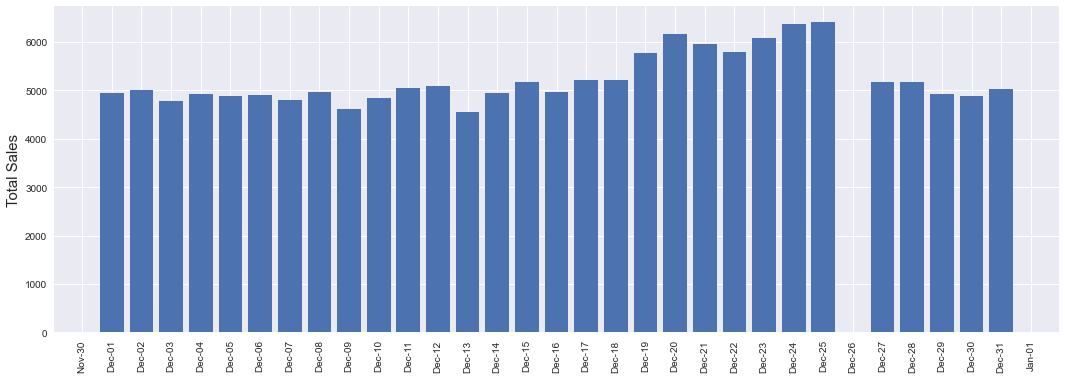

In [37]:
fig = plt.figure(figsize=(18,6))
plt.bar(december.index,december.sales)
ax = plt.gca()
formatter = mdates.DateFormatter("%b-%d")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.DayLocator()
ax.xaxis.set_major_locator(locator)
plt.ylabel("Total Sales",{'fontsize':15})
plt.xticks(rotation='vertical')
plt.savefig('TOT_Sales_DEC')
plt.show()

Here we can see that store was closed after the day of Christmas and relatively high sales on and before Christmas (Dec-25th). 

Now let's see the PROD_WT that we created at the beginning.

In [38]:
transactionData['PROD_WT'].head()

0    175
1    175
2    170
3    175
4    150
Name: PROD_WT, dtype: int64

In [39]:
transactionData["PROD_WT"].unique()

array([175, 170, 150, 330, 210, 270, 220, 125, 110, 134, 380, 180, 165,
       135, 250, 200, 160, 190,  90,  70], dtype=int64)

Text(0.5, 1.0, 'Product Weight Frequency')

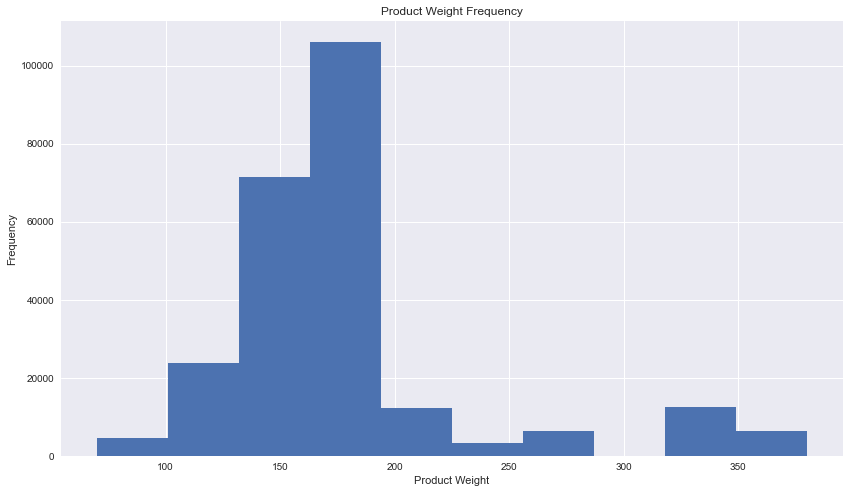

In [40]:
plt.figure(figsize=(14,8))
plt.hist(transactionData["PROD_WT"])
plt.xlabel("Product Weight")
plt.ylabel("Frequency")
plt.title("Product Weight Frequency")

Now let's see the transactions on the basis of BRAND which we obtained before from column PROD_NAME

In [41]:
transactionData["BRAND"].head()

0    Natural
1        CCs
2     Smiths
3     Smiths
4     Kettle
Name: BRAND, dtype: object

In [42]:
transactionData["BRAND"].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [43]:
# As we can see many have duplicate names, rename those for better understanding.

transactionData["BRAND"].replace('NCC','Natural',inplace = True)
transactionData["BRAND"].replace('CCs','CCS',inplace = True)
transactionData["BRAND"].replace('Smith','Smiths',inplace = True)
transactionData["BRAND"].replace(['Grain','GrnWves'],'Grainwaves',inplace = True)
transactionData["BRAND"].replace('Dorito','Doritos',inplace = True)
transactionData["BRAND"].replace('WW','Woolworths',inplace = True)
transactionData["BRAND"].replace(['Red','RRD'],'Red Rock Deli',inplace = True)
transactionData["BRAND"].replace('Infzns','Infuzions',inplace = True)
transactionData["BRAND"].replace('Snbts','Sunbites',inplace = True)

transactionData["BRAND"].unique()

array(['Natural', 'CCS', 'Smiths', 'Kettle', 'Grainwaves', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

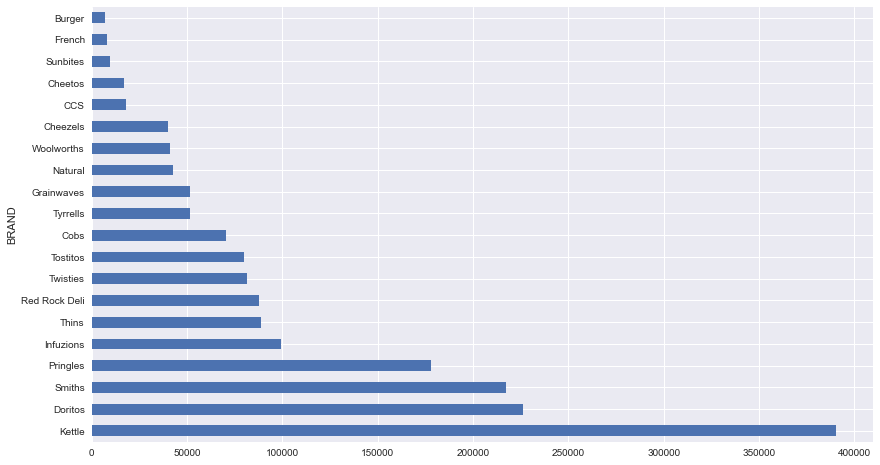

In [83]:
#Which brand has more sales.
brand = transactionData.groupby("BRAND").TOT_SALES.sum().sort_values(ascending=False)

brand.plot(kind='barh',figsize=(14,8))
plt.savefig('Sales_Brand')

Maximum number of transactions are for brand Kettle

### Customer Data Analysis

In [45]:
purchaseData.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [46]:
purchaseData.shape

(72636, 3)

In [47]:
purchaseData.nunique()

LYLTY_CARD_NBR      72636
LIFESTAGE               7
PREMIUM_CUSTOMER        3
dtype: int64

In [48]:
purchaseData.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [49]:
purchaseData['LIFESTAGE'].value_counts().sort_values(ascending=False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

<AxesSubplot:xlabel='count', ylabel='LIFESTAGE'>

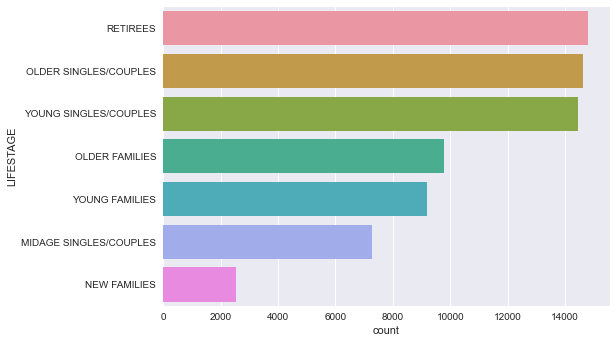

In [50]:
sns.countplot(y=purchaseData['LIFESTAGE'],order = purchaseData['LIFESTAGE'].value_counts().index)

Most of the customers are from the three categories of Lifestages only.

In [51]:
purchaseData['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending=False)

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

<AxesSubplot:xlabel='count', ylabel='PREMIUM_CUSTOMER'>

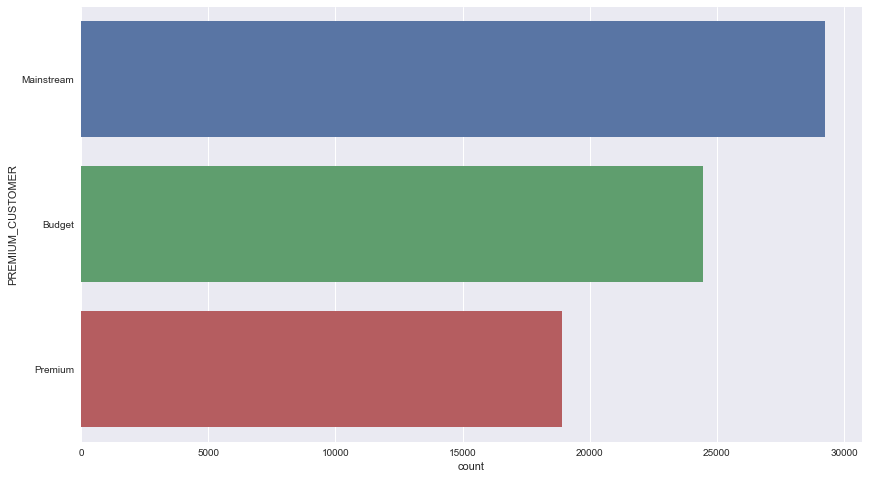

In [52]:
plt.figure(figsize=(14,8))
sns.countplot(y=purchaseData['PREMIUM_CUSTOMER'],order=purchaseData['PREMIUM_CUSTOMER'].value_counts().index)

### Merging Transaction Data and Purchase Data

In [53]:
combine_data = transactionData.join(purchaseData.set_index('LYLTY_CARD_NBR'),on = 'LYLTY_CARD_NBR')
combine_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-18,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-15,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-21,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-18,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-19,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [54]:
combine_data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PROD_WT             0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [55]:
combine_data.shape

(246740, 12)

In [56]:
# Total sales by PREMIUM_CUSTOMER and LIFESTAGE

sales = combine_data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).agg({'TOT_SALES':'sum','PROD_QTY':'sum'}).reset_index().sort_values('TOT_SALES')
sales['SEGMENT'] = sales.LIFESTAGE + ' '+ sales.PREMIUM_CUSTOMER

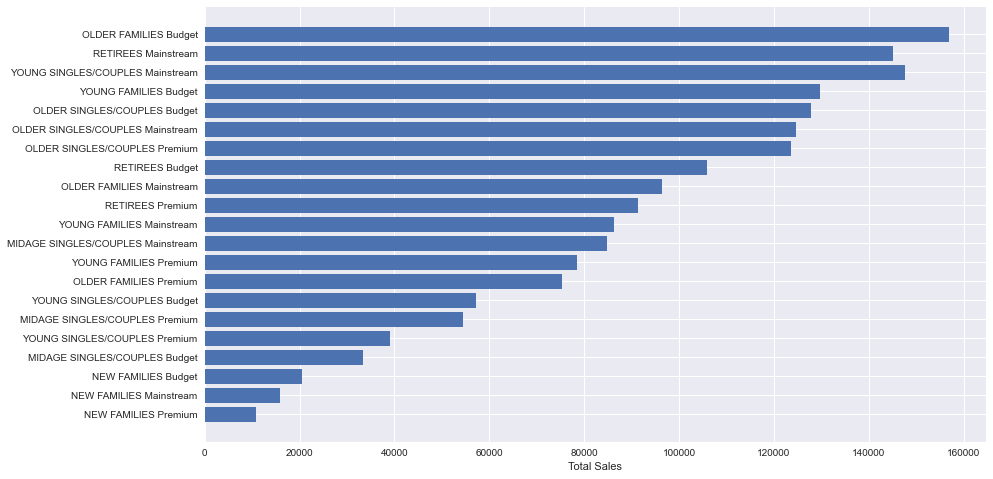

In [86]:
x= list(sales.SEGMENT)
y=list(sales.TOT_SALES)
plt.figure(figsize=(14,8))
plt.xlabel('Total Sales')

plt.barh(x,y)
plt.savefig('Category total sales')


Maximum Sales are from the category Older Families Budget

<BarContainer object of 21 artists>

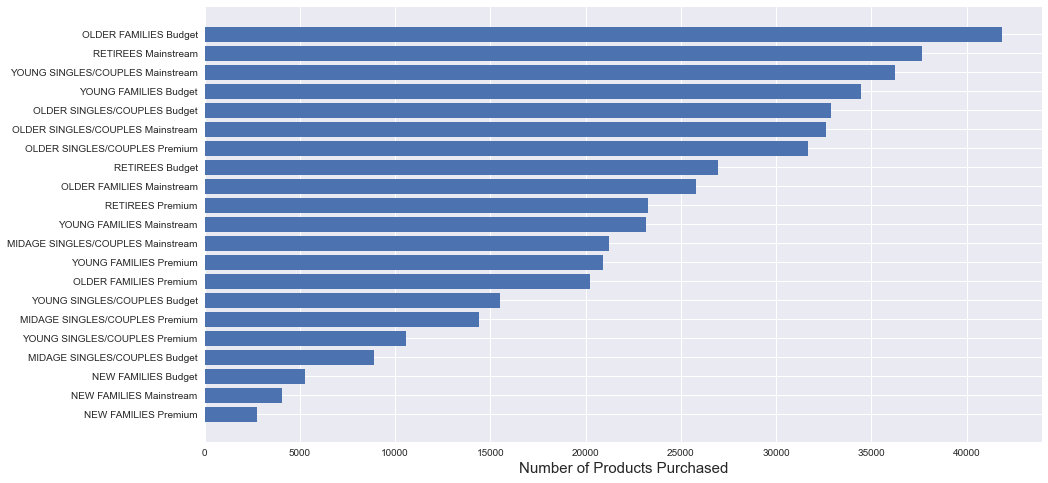

In [58]:
#Number of products purchased

sales = sales.sort_values("PROD_QTY")
x = list(sales.SEGMENT)
y = list(sales.PROD_QTY)
plt.figure(figsize=(15,8))
plt.xlabel("Number of Products Purchased",{'fontsize':15})
plt.barh(x,y)

Max number of products purchased by the Budget Older Families

In [59]:
#Number of customers by PREMIUM_CUSTOMER and LIFESTAGE

customers = combine_data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).LYLTY_CARD_NBR.nunique().reset_index()
customers.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
customers = customers.sort_values(by = 'Number of Customers', ascending = False)
customers['SEGMENT'] = customers.LIFESTAGE + '_' + customers.PREMIUM_CUSTOMER
customers.head()

,PREMIUM_CUSTOMER,LIFESTAGE,Number of Customers,SEGMENT
13,Mainstream,YOUNG SINGLES/COUPLES,7917,YOUNG SINGLES/COUPLES_Mainstream
11,Mainstream,RETIREES,6358,RETIREES_Mainstream
10,Mainstream,OLDER SINGLES/COUPLES,4858,OLDER SINGLES/COUPLES_Mainstream
3,Budget,OLDER SINGLES/COUPLES,4849,OLDER SINGLES/COUPLES_Budget
17,Premium,OLDER SINGLES/COUPLES,4682,OLDER SINGLES/COUPLES_Premium


<BarContainer object of 21 artists>

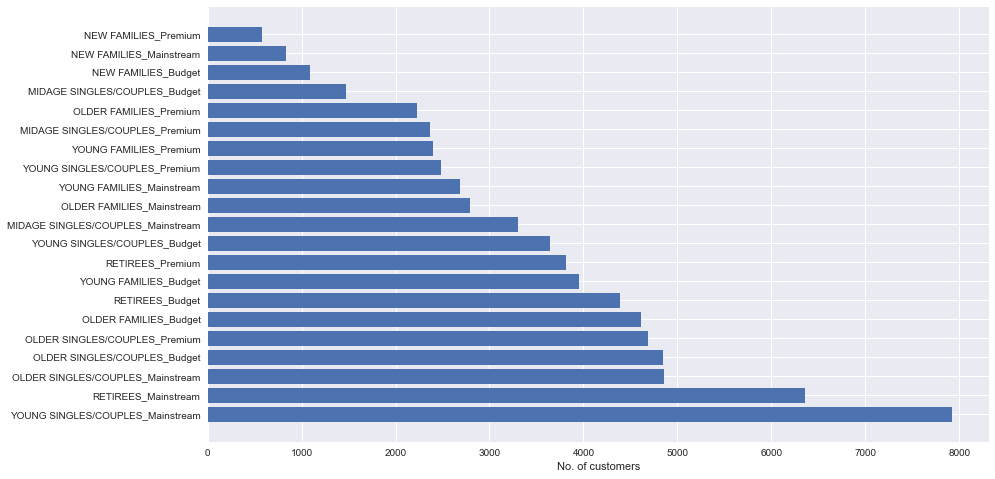

In [60]:
x= list(customers.SEGMENT)
y=list(customers["Number of Customers"])
plt.figure(figsize=(14,8))
plt.xlabel('No. of customers')
plt.barh(x,y)

We can observe that many customers are Young Singles/Couples Mainstream and Retirees Mainstream

In [61]:
# Average units per customer

avg = combine_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum() / combine_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique()
avg = pd.DataFrame(avg, columns = {'Average Unit per Customer'})
avg = avg.sort_values(by = 'Average Unit per Customer', ascending = False)

In [62]:
avg.head()

Average Unit per Customer
LIFESTAGE      PREMIUM_CUSTOMER                           
OLDER FAMILIES Mainstream                         9.255380
               Budget                             9.076773
               Premium                            9.071717
YOUNG FAMILIES Budget                             8.722995
               Premium                            8.716013

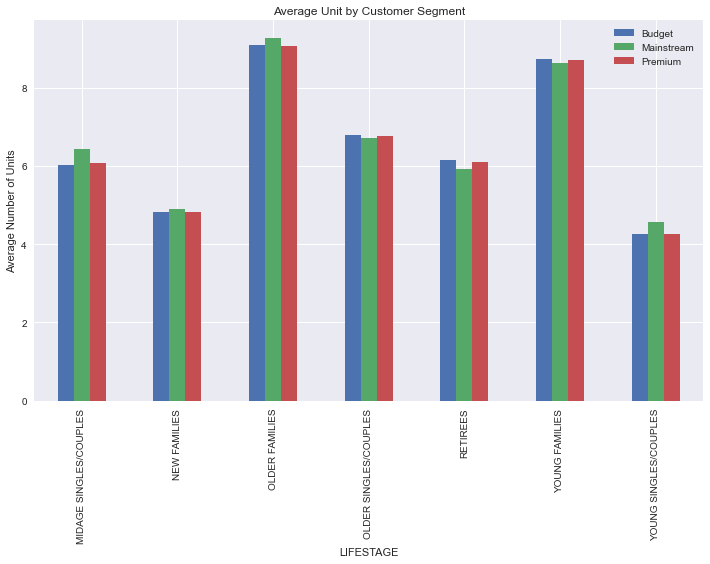

In [87]:
# Visualise 

avg.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Unit by Customer Segment')
plt.ylabel('Average Number of Units')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 1)
plt.savefig("Avg unit by customer")

Older and Young Families buys more chips per customer

In [64]:
# Average price per unit

avg_price = combine_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).TOT_SALES.sum() / combine_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price = avg_price.sort_values(by = 'Price per Unit', ascending = False)

In [65]:
avg_price.head()

,,Price per Unit
LIFESTAGE,PREMIUM_CUSTOMER,
YOUNG SINGLES/COUPLES,Mainstream,4.074043
MIDAGE SINGLES/COUPLES,Mainstream,3.994449
NEW FAMILIES,Mainstream,3.935887
RETIREES,Budget,3.932731
NEW FAMILIES,Budget,3.931969


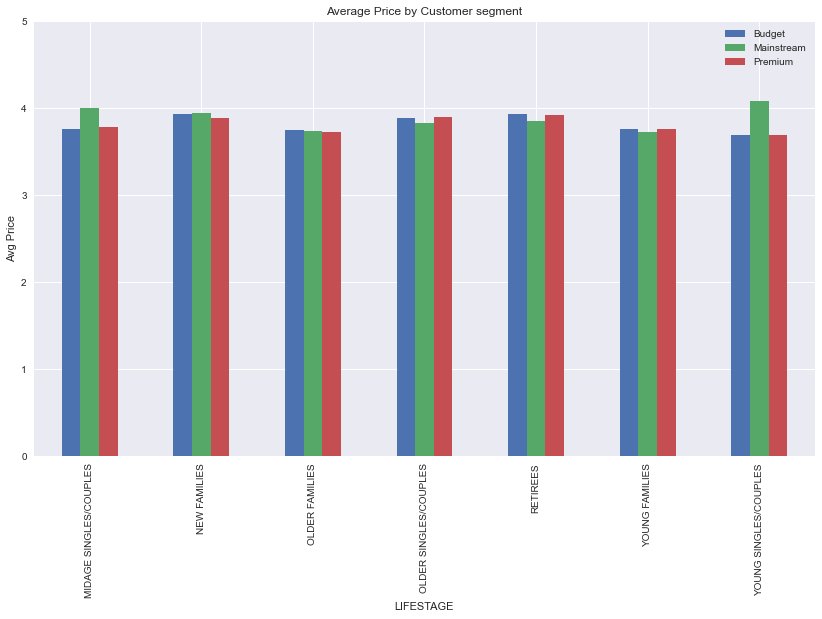

In [66]:
avg_price.unstack().plot(kind='bar', figsize = (14,8), title = "Average Price by Customer segment",ylim= (0,5))
plt.ylabel("Avg Price")
plt.legend(['Budget','Mainstream','Premium'],loc=1)

Mainstream Midage and Young Singles/Couples pay more per packet of chips compared to their budget and premium counterparts

In [67]:
# Perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples to test this difference

#New DataFrame
priceperunit = combine_data

priceperunit['Price'] = priceperunit['TOT_SALES'] / priceperunit['PROD_QTY']

priceperunit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Price
0,2018-10-18,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-15,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2019-05-21,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45
3,2018-08-18,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget,3.00
4,2018-08-19,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget,4.60


In [68]:
# Grouping our data into mainstream and nonMainstream customers

mainstream = priceperunit.loc[(priceperunit['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (priceperunit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (priceperunit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'Price']
nonMainstream = priceperunit.loc[(priceperunit['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (priceperunit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (priceperunit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'Price']

In [69]:
print("Mainstream average price per unit: ${:.2f}".format(np.mean(mainstream)))
print("nonMainstream average price per unit: ${:.2f}".format(np.mean(nonMainstream)))

Mainstream average price per unit: $4.04
nonMainstream average price per unit: $3.71


Mainstream customers have higher avg price per unit

In [70]:
# Performing t-test
from scipy.stats import ttest_ind

ttest_ind(mainstream , nonMainstream)

Ttest_indResult(statistic=37.83196107667815, pvalue=2.235645611549355e-309)

Since the value of p < 0.05 e reject the null hypothesis and as t = 37.832 we can conclude that the unit price for mainstream,young and midage singles/couples is significantly higher than that of budget or premium categories.

Now we can only target the customer segments that contribute the most to the total sales. So let's examine mainstream young singles/couples and see if they have any particular taste.

In [71]:
# Target dataset

target = combine_data.loc[(combine_data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (combine_data['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
nonTarget = combine_data.loc[(combine_data['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (combine_data['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
target.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Price
237702,2018-08-17,1,1020,26,19,Smiths Crinkle Cut Snag Sauce,1,2.6,150,Smiths,YOUNG SINGLES/COUPLES,Mainstream,2.6
237703,2018-08-18,1,1163,188,46,Kettle Original,1,5.4,175,Kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
237704,2018-08-15,1,1291,333,27,Ww Supreme Cheese Corn Chips,1,1.9,200,Woolworths,YOUNG SINGLES/COUPLES,Mainstream,1.9
237705,2019-05-16,3,3031,1227,14,Smiths Crnkle Chip Orgnl Big Bag,1,5.9,380,Smiths,YOUNG SINGLES/COUPLES,Mainstream,5.9
237706,2019-05-19,3,3118,1574,62,Pringles Mystery Flavour,1,3.7,134,Pringles,YOUNG SINGLES/COUPLES,Mainstream,3.7


### Affinity to Brand
Checking which brand is favoured by the target segment

In [72]:
# Target Segment
targetBrand = target.loc[:, ['BRAND', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())

targetBrand.head()


,Target Brand Affinity
BRAND,
Burger,0.002926
CCS,0.011180
Cheetos,0.008033
Cheezels,0.017971
Cobs,0.044638


In [73]:
# Non-target segment
nonTargetBrand = nonTarget.loc[:, ['BRAND', 'PROD_QTY']]
nonTargetSum = nonTargetBrand['PROD_QTY'].sum()
nonTargetBrand['Non-Target Brand Affinity'] = nonTargetBrand['PROD_QTY'] / nonTargetSum
nonTargetBrand = pd.DataFrame(nonTargetBrand.groupby('BRAND')['Non-Target Brand Affinity'].sum())

nonTargetBrand.head()

,Non-Target Brand Affinity
BRAND,
Burger,0.006538
CCS,0.018445
Cheetos,0.011759
Cheezels,0.018904
Cobs,0.038449


In [74]:
brand_proportions = pd.merge(targetBrand, nonTargetBrand, left_index = True, right_index = True)
brand_proportions.head()

,Target Brand Affinity,Non-Target Brand Affinity
BRAND,,
Burger,0.002926,0.006538
CCS,0.011180,0.018445
Cheetos,0.008033,0.011759
Cheezels,0.017971,0.018904
Cobs,0.044638,0.038449


In [75]:
brand_proportions['Affinity to Brand'] = brand_proportions['Target Brand Affinity'] / brand_proportions['Non-Target Brand Affinity']
brand_proportions.sort_values(by = 'Affinity to Brand', ascending = False).head()

,Target Brand Affinity,Non-Target Brand Affinity,Affinity to Brand
BRAND,,,
Tyrrells,0.031553,0.025715,1.227025
Twisties,0.046184,0.037933,1.217506
Doritos,0.122761,0.101171,1.213397
Kettle,0.197985,0.166560,1.188667
Tostitos,0.045411,0.038350,1.184100


Mainstream Young singles/couples are more likely to purchase Tyrrells over other brands

### Affinity to Pack Size

In [76]:
# Target segment 
targetSize = target.loc[:, ['PROD_WT', 'PROD_QTY']]
targetSum = targetSize['PROD_QTY'].sum()
targetSize['Target Pack Affinity'] = targetSize['PROD_QTY'] / targetSum
targetSize = pd.DataFrame(targetSize.groupby('PROD_WT')['Target Pack Affinity'].sum())

targetSize.head()

,Target Pack Affinity
PROD_WT,
70,0.003037
90,0.006349
110,0.106280
125,0.003009
134,0.119420


In [77]:
# Non-target segment
nonTargetSize = nonTarget.loc[:, ['PROD_WT', 'PROD_QTY']]
nonTargetSum = nonTargetSize['PROD_QTY'].sum()
nonTargetSize['Non-Target Pack Affinity'] = nonTargetSize['PROD_QTY'] / nonTargetSum
nonTargetSize = pd.DataFrame(nonTargetSize.groupby('PROD_WT')['Non-Target Pack Affinity'].sum())

nonTargetSize.head()

,Non-Target Pack Affinity
PROD_WT,
70,0.006284
90,0.012613
110,0.089575
125,0.005976
134,0.101110


In [78]:
pack_proportions = pd.merge(targetSize, nonTargetSize, left_index = True, right_index = True)
pack_proportions.head()

,Target Pack Affinity,Non-Target Pack Affinity
PROD_WT,,
70,0.003037,0.006284
90,0.006349,0.012613
110,0.106280,0.089575
125,0.003009,0.005976
134,0.119420,0.101110


In [79]:
pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity'] / pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by = 'Affinity to Pack', ascending = False).head()

,Target Pack Affinity,Non-Target Pack Affinity,Affinity to Pack
PROD_WT,,,
270,0.031829,0.025070,1.269608
380,0.032160,0.025711,1.250827
330,0.061284,0.050974,1.202243
110,0.106280,0.089575,1.186492
134,0.119420,0.101110,1.181090


Mainstream Young singles/couples are more likely to purchase a 270g pack

Let's identify which brand provides 270g pack

In [80]:
combine_data.loc[combine_data['PROD_WT'] == 270, :].head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,Price
12,2019-05-19,9,9208,8634,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
42,2019-05-21,55,55073,48887,113,Twisties Chicken,1,4.6,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
69,2019-05-21,88,88320,87811,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
104,2018-08-21,149,149317,149044,15,Twisties Cheese,1,4.6,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
110,2018-08-16,153,153220,152829,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
130,2018-08-19,173,173154,174551,15,Twisties Cheese,1,4.6,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
161,2018-08-18,217,217168,217061,113,Twisties Chicken,1,4.6,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
162,2019-05-19,219,219065,218396,15,Twisties Cheese,1,4.6,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
219,2019-04-22,1,1491,577,113,Twisties Chicken,1,4.6,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
270,2019-07-01,4,4106,3138,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6


In [81]:
combine_data.loc[combine_data['PROD_WT'] == 270, 'BRAND'].unique()

array(['Twisties'], dtype=object)

Only Twisties provides 270g pack size.

## Conclusion 

1. In month of December there was unusual high sales might be due to the Christmas.
2. Later we observe that maximum number of transactions are for the brand KETTLE.
3. Total Sales are highest for Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees shoppers.
4. Than we got to know that high sales for Mainstream - young singles/couples, and Mainstream - retirees is due to the fact that there are more customers in that segment.
5. Mainstream Midage and Young Singles/Couples pay more per packet of chips compared to their budget and premium counterparts. Indicates impulse buying behaviour.
6. We’ve also found that Mainstream young singles and couples are more likely to purchase Tyrrells chips.
7. Finally, Affinity analysis of Mainstream young singles and couples suggests that they are more likely to purchase brand "Tyrrells" and packet size of "270g" which is only provided by the brand "Twisties".